In [483]:
import pandas as pd

import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import stdtr
from statsmodels.stats.multitest import fdrcorrection



In [445]:
def linear_regression(warped_screens, warped_intercept):
    list_ind_err = []
    GLS_coef = np.empty((len(warped_screens), len(warped_screens)))
    GLS_se = np.empty((len(warped_screens), len(warped_screens)))
    ys = warped_screens.T
    for gene_index in range(len(warped_screens)):
        X = np.stack((warped_intercept, warped_screens[gene_index]), axis=1)
        coef, residues = np.linalg.lstsq(X, ys, rcond=None)[:2]
        df = warped_screens.shape[1] - 2
        GLS_coef[gene_index] = coef[1]
        try:
            GLS_se[gene_index] = \
                np.sqrt(np.linalg.pinv(X.T @ X)[1, 1] * residues / df)
        except Exception as e: 
            print(e)
            print(gene_index)
            list_ind_err.append(gene_index)
            
    return GLS_coef, GLS_se, list_ind_err

In [447]:
# LFC dataset
fn_lfc = '../data/standardized_data/old_std_data/result_logfc_matrix_2021_11_15_BASIS_invitro.csv'
df_lfc_gls = pd.read_csv(fn_lfc, index_col=0)
df_lfc_gls.dropna(axis=0, inplace=True)

mat_data = df_lfc_gls.values


In [435]:
cov_mat = np.cov(mat_data.T)
inv_mat = np.linalg.inv(cov_mat)

cholsigmainv = np.linalg.cholesky(inv_mat)
warped_screens = df_lfc_gls.values @ cholsigmainv
warped_intercept = cholsigmainv.sum(axis=0)

print(mat_data.shape, warped_screens.shape, cov_mat.shape, cholsigmainv.shape, warped_intercept.shape)

(3971, 125) (3971, 125) (125, 125) (125, 125) (125,)


## GLS regression

In [ ]:
GLS_coef, GLS_se, list_ind_err_GLS = linear_regression(warped_screens, warped_intercept)

In [466]:
list_genes_err = df_lfc_gls.index[list_ind_err_GLS].tolist()
list_ind_good = [i for i in np.arange(len(warped_screens)) if not i in list_ind_err_GLS]
GLS_coef_filt = GLS_coef[:,list_ind_good][list_ind_good]
GLS_se_filt = GLS_se[:,list_ind_good][list_ind_good]
GLS_coef.shape, GLS_coef_filt.shape

((3971, 3971), (3959, 3959))

In [468]:
# p-values: 
df = warped_screens.shape[1] - 2
GLS_p = 2 * stdtr(df, -np.abs(GLS_coef_filt / GLS_se_filt))
np.fill_diagonal(GLS_p, 1)

In [496]:
genes = df_lfc_gls.index[list_ind_good].to_series().squeeze()
GLS_p_df = pd.DataFrame( GLS_p, columns=genes, index=genes )

# Benjamini/Hochberg corrected p-values: 
stacked_p = GLS_p_df.stack()
stacked_p = stacked_p[stacked_p.index.get_level_values(0) < stacked_p.index.get_level_values(1)]
fdr_GLS = pd.Series(fdrcorrection(stacked_p)[1], index=stacked_p.index)
# set threshold and create gene pair dataframe
th = 0.001
fdr_th_GLS = fdr_GLS[fdr_GLS.values<=th].copy()

In [497]:
# Define a range of threshold values
thresholds = np.logspace(-4, -1, 20)  # Example: 20 thresholds from 0.0001 to 0.1
# Count the number of significant gene pairs for each threshold
significant_counts_GLS = []
for th in thresholds:
    count = (fdr_GLS <= th).sum()
    significant_counts_GLS.append(count)

## OLS regression

In [ ]:
OLS_intercept = np.ones(mat_data.shape[1])  # Assuming that mat_data's cols correspond to screens
OLS_coef, OLS_se, list_ind_err_OLS = linear_regression(mat_data, OLS_intercept)

In [471]:
list_genes_err = df_lfc_gls.index[list_ind_err_OLS].tolist()
list_ind_good = [i for i in np.arange(len(warped_screens)) if not i in list_ind_err_OLS]
OLS_coef_filt = OLS_coef[:,list_ind_good][list_ind_good]
OLS_se_filt = OLS_se[:,list_ind_good][list_ind_good]
OLS_coef.shape, OLS_coef_filt.shape

((3971, 3971), (3959, 3959))

In [472]:
# p-values
df = warped_screens.shape[1] - 2
OLS_p = 2 * stdtr(df, -np.abs(OLS_coef_filt / OLS_se_filt))
np.fill_diagonal(OLS_p, 1)

In [498]:
genes = df_lfc_gls.index[list_ind_good].to_series().squeeze()
OLS_p_df = pd.DataFrame( OLS_p, columns=genes, index=genes )

# Benjamini/Hochberg corrected p-values: 
stacked_p = OLS_p_df.stack()
stacked_p = stacked_p[stacked_p.index.get_level_values(0) < stacked_p.index.get_level_values(1)]
fdr_OLS = pd.Series(fdrcorrection(stacked_p)[1], index=stacked_p.index)
# set threshold and create gene pair dataframe
th = 0.001
fdr_th_OLS = fdr_GLS[fdr_OLS.values<=th].copy()

In [499]:
# Define a range of threshold values
thresholds = np.logspace(-4, -1, 20)  # Example: 20 thresholds from 0.0001 to 0.1
# Count the number of significant gene pairs for each threshold
significant_counts_OLS = []
for th in thresholds:
    count = (fdr_OLS <= th).sum()
    significant_counts_OLS.append(count)

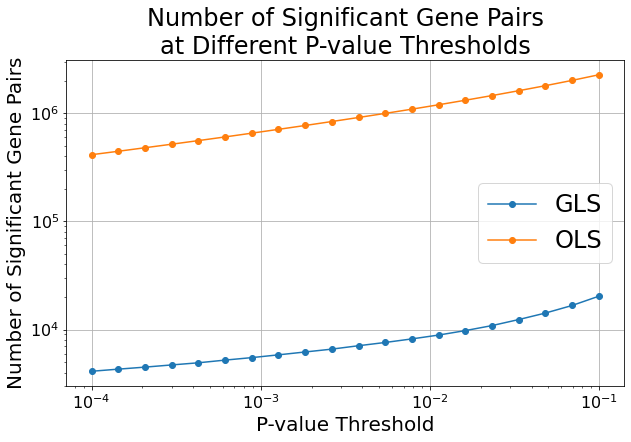

In [511]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, significant_counts_GLS, marker='o')
plt.plot(thresholds, significant_counts_OLS, marker='o')
plt.xscale('log')  # Since thresholds are on a log scale
plt.xlabel('P-value Threshold', fontsize = 20)
plt.ylabel('Number of Significant Gene Pairs', fontsize = 20)
plt.title('Number of Significant Gene Pairs\nat Different P-value Thresholds', fontsize = 24)
plt.legend(['GLS', 'OLS'], fontsize = 24)
plt.yscale('log')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.grid(True)

# Towards understanding GLS

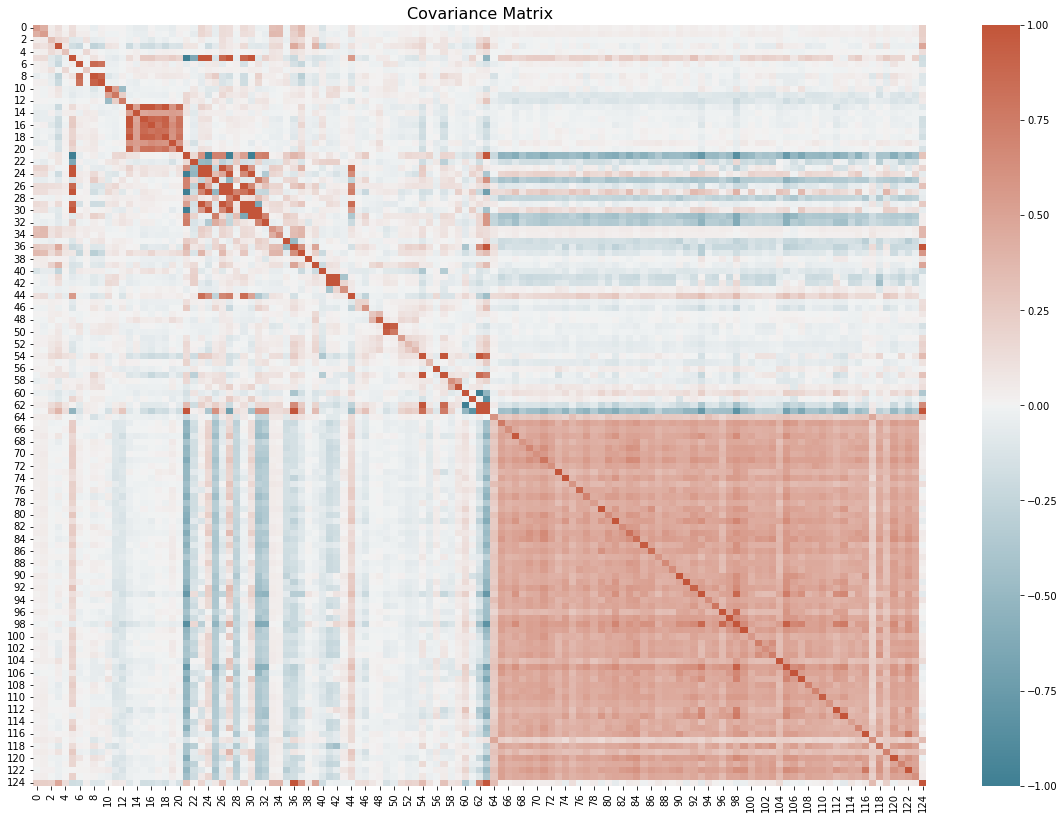

In [245]:
# Visualize the covariance matrix
plt.figure(figsize = (20,14))
# Set the center of the colormap at 0
center_val = 0

# Choose a diverging colormap that clearly differentiates positive and negative values
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(cov_mat, annot=False, cmap=cmap, center=center_val, vmin=-1, vmax=1)
ttl = plt.title("Covariance Matrix", fontsize = 16)

In [246]:
warped_screens = df_lfc_gls.values @ cholsigmainv
warped_cov_mat = np.cov(warped_screens.T)

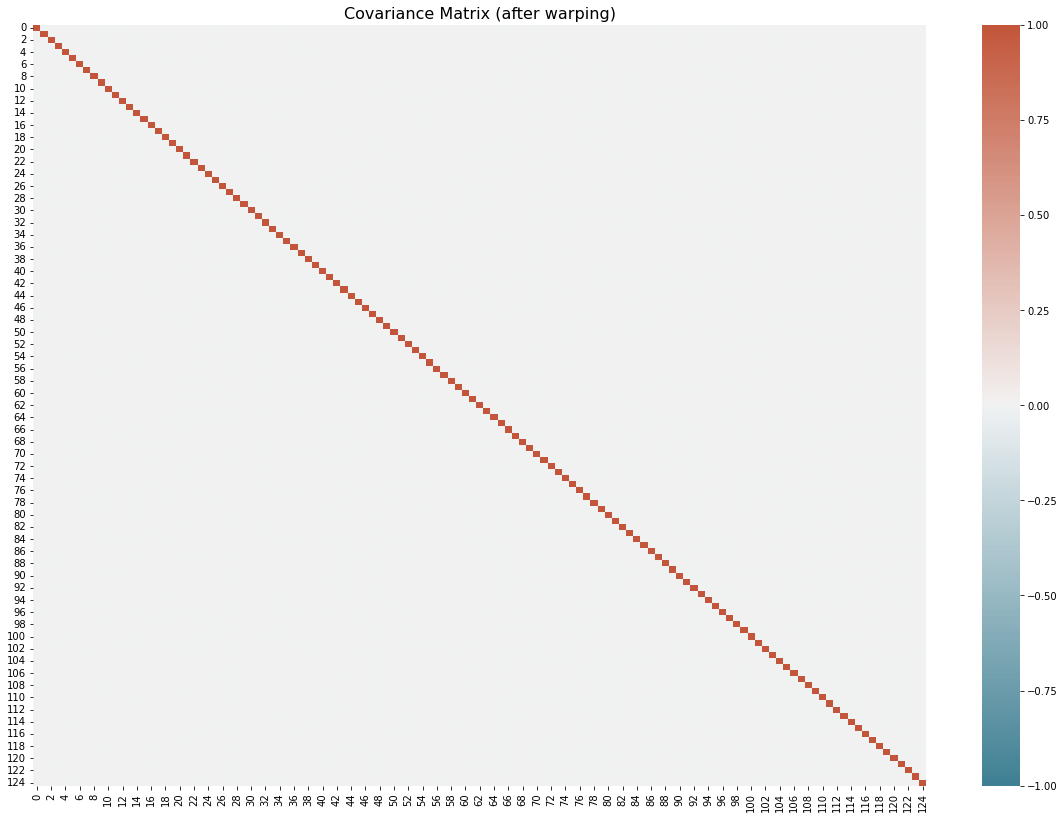

In [247]:
# Visualize the covariance matrix
plt.figure(figsize = (20,14))
# Set the center of the colormap at 0
center_val = 0

# Choose a diverging colormap that clearly differentiates positive and negative values
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(warped_cov_mat, annot=False, cmap=cmap, center=center_val, vmin=-1, vmax=1)
ttl = plt.title("Covariance Matrix (after warping)", fontsize = 16)

-0.17785889224311996 0.016062714944254184


Text(0.5, 1.0, 'scatter plot')

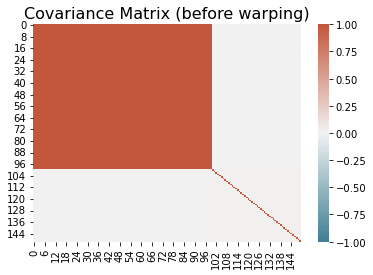

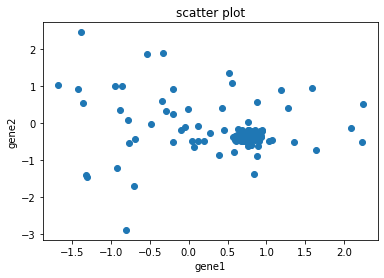

In [423]:
# Adjusting the covariance matrix to simulate batch effects
cov_screens_batch_effect = np.eye(num_screens)  # Start with no correlation

# Introducing high correlation among a batch of 50 screens
high_correlation = 0.99
num_hc = 100
for i in range(num_hc):
    for j in range(num_hc):
        if i != j:
            cov_screens_batch_effect[i, j] = high_correlation

# The rest of the screens have lower or negligible correlations
low_correlation = 0.01
for i in range(num_hc, num_screens):
    for j in range(num_hc, num_screens):
        if i != j:
            cov_screens_batch_effect[i, j] = low_correlation


sns.heatmap(cov_screens_batch_effect, annot=False, cmap=cmap, center=center_val, vmin=-1, vmax=1)
ttl = plt.title("Covariance Matrix (before warping)", fontsize = 16)


# Generating new screen data with the adjusted covariance matrix
screen_data_batch_effect = np.random.multivariate_normal(mean_screens, cov_screens_batch_effect, size=num_genes).T

# Converting to DataFrame for easier manipulation
df_screen_data_batch_effect = pd.DataFrame(screen_data_batch_effect, columns=[f"Gene_{i}" for i in range(num_genes)])

# Picking two genes to analyze their correlation using OLS
gene1_batch_effect = df_screen_data_batch_effect['Gene_100']
gene2_batch_effect = df_screen_data_batch_effect['Gene_1']

# Performing OLS to find correlation between two genes
X_batch_effect = sm.add_constant(gene1_batch_effect)  # Adding a constant term
model_batch_effect = sm.OLS(gene2_batch_effect, X_batch_effect).fit()

# Getting the OLS results from the batch effect data
ols_coefficient_batch_effect, ols_p_value_batch_effect = model_batch_effect.params[1], model_batch_effect.pvalues[1]

print(ols_coefficient_batch_effect, ols_p_value_batch_effect)

plt.figure()
pplltt = plt.scatter(gene1_batch_effect, gene2_batch_effect)
plt.xlabel('gene1')
yl = plt.ylabel('gene2')
plt.title('scatter plot')


In [426]:
screen_data_batch_effect.shape

(150, 4000)

In [424]:
from statsmodels.regression.linear_model import GLS

# Subsampling a reasonable number of gene pairs for analysis
# For computational feasibility, let's consider 1000 gene pairs
num_pairs = 1000
np.random.seed(42)  # Seed for reproducibility
subsampled_pairs = [np.random.choice(num_genes, 2, replace=False) for _ in range(num_pairs)]

# Preparing the covariance matrix for GLS
inv_cov_mat = np.linalg.inv(cov_screens_batch_effect)
chol_inv_cov_mat = np.linalg.cholesky(inv_cov_mat).T

# Function to perform OLS and GLS on a gene pair and return p-values
def analyze_gene_pair(gene_pair, data, chol_inv_cov_mat):
    gene1_data = data.iloc[:, gene_pair[0]]
    gene2_data = data.iloc[:, gene_pair[1]]
    
    # OLS Analysis
    X_ols = sm.add_constant(gene1_data)
    ols_model = sm.OLS(gene2_data, X_ols).fit()
    ols_p_value = ols_model.pvalues[1]
    
    # GLS Analysis
    X_gls = X_ols @ chol_inv_cov_mat  # Transforming the data for GLS
    gls_model = GLS(gene2_data @ chol_inv_cov_mat, X_gls).fit()
    gls_p_value = gls_model.pvalues[1]
    
    return ols_p_value, gls_p_value

# Analyzing the subsampled gene pairs
ols_significant = 0
gls_significant = 0
p_value_threshold = 0.05  # Common threshold for significance

for pair in subsampled_pairs:
    ols_p, gls_p = analyze_gene_pair(pair, df_screen_data_batch_effect, chol_inv_cov_mat)
    
    if ols_p < p_value_threshold:
        ols_significant += 1
    if gls_p < p_value_threshold:
        gls_significant += 1

ols_significant, gls_significant



ValueError: Dot product shape mismatch, (150, 2) vs (150, 150)

# OLS

In [42]:
# Generating synthetic data
np.random.seed(0)
X = np.random.rand(100, 1)  # 100 data points
X = sm.add_constant(X)  # Adding a constant for the intercept
true_beta = [1, 2]  # True coefficients
y = np.dot(X, true_beta) + np.random.normal(scale=1, size=100)  # Adding some noise

In [43]:
# Fitting OLS model
model_ols = sm.OLS(y, X).fit()
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     30.79
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           2.45e-07
Time:                        09:25:52   Log-Likelihood:                -141.51
No. Observations:                 100   AIC:                             287.0
Df Residuals:                      98   BIC:                             292.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2222      0.193      6.323      0.0

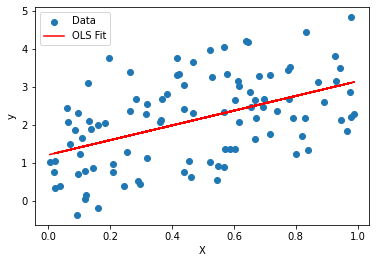

In [44]:
# Plotting the data and the OLS fit
plt.scatter(X[:, 1], y, label='Data')
plt.plot(X[:, 1], model_ols.fittedvalues, color='red', label='OLS Fit')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Exercise number 2: 

In [218]:
# Set seed for reproducibility
np.random.seed(0)

# Generate synthetic data
n_samples = 1000
gene1 = np.random.normal(0, 1, n_samples)  # Gene 1 log2 fold change
gene2 = 0.5 * gene1 + np.random.normal(0, 1, n_samples)  # Gene 2, correlated with Gene 1
gene3 = np.random.normal(0, 1, n_samples)  # Gene 3, independent

# Combine into a DataFrame
data = pd.DataFrame({'gene1': gene1, 'gene2': gene2, 'gene3': gene3})

In [219]:
X = data.values
# Compute the covariance matrix
cov_matrix = np.cov(X.T)  # Transpose X to get variables as columns
print("Covariance Matrix:\n", cov_matrix)

Covariance Matrix:
 [[ 0.97520967  0.4574652  -0.03552582]
 [ 0.4574652   1.15193481 -0.01835972]
 [-0.03552582 -0.01835972  0.91125022]]


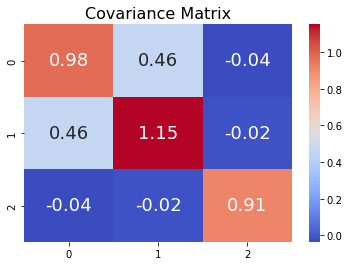

In [220]:
# Visualize the covariance matrix
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":18})
ttl = plt.title("Covariance Matrix", fontsize = 16)

                            OLS Regression Results                            
Dep. Variable:                  gene2   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     228.5
Date:                Wed, 20 Dec 2023   Prob (F-statistic):           1.23e-46
Time:                        12:37:40   Log-Likelihood:                -1386.1
No. Observations:                1000   AIC:                             2776.
Df Residuals:                     998   BIC:                             2786.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.031      0.398      0.6

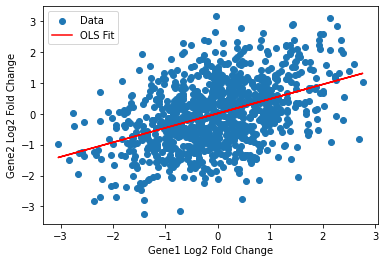

In [223]:
# Adding a constant for the intercept in the model
X = sm.add_constant(data['gene1'])


# Fitting OLS model for gene1 vs gene2
model_ols = sm.OLS(data['gene2'], X).fit()
print(model_ols.summary())

# Plotting the data and the OLS fit
plt.scatter(data['gene1'], data['gene2'], label='Data')
plt.plot(data['gene1'], model_ols.fittedvalues, color='red', label='OLS Fit')
plt.xlabel('Gene1 Log2 Fold Change')
plt.ylabel('Gene2 Log2 Fold Change')
plt.legend()
plt.show()


# GLS: 

In [ ]:
# Hypothetical heteroscedasticity - variance increases with the value of gene1
weights = 1 + data['gene1']**2

# Apply GLS
model_gls = sm.GLS(data['gene2'], X, sigma=weights).fit()
print(model_gls.summary())

# Plotting the data and the GLS fit
plt.scatter(data['gene1'], data['gene2'], label='Data')
plt.plot(data['gene1'], model_gls.fittedvalues, color='green', label='GLS Fit')
plt.xlabel('Gene1 Log2 Fold Change')
plt.ylabel('Gene2 Log2 Fold Change')
plt.legend()
plt.show()
